<a href="https://colab.research.google.com/github/Salma-Kassem/DeepLearning/blob/main/RBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist

# Load data
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Normalize to [0, 1]
x_train = x_train.astype(np.float32) / 255.
x_test = x_test.astype(np.float32) / 255.

# Flatten images for RBM input (28*28=784)
x_train_flat = x_train.reshape(-1, 784)
x_test_flat = x_test.reshape(-1, 784)




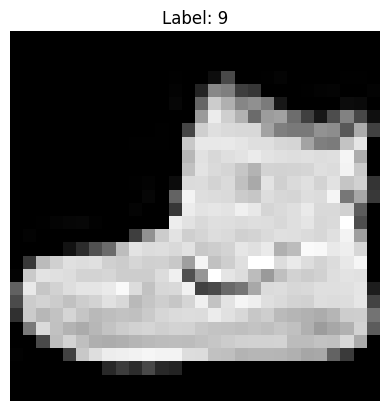

In [ ]:
import matplotlib.pyplot as plt

# Pick an example image
index = 0
image = x_train[index]  # shape: (28, 28)
label = y_train[index]

# Display
plt.imshow(image, cmap='gray')
plt.title(f"Label: {label}")
plt.axis('off')  # hides the axis for clarity
plt.show()


# **RBM clas**

In [ ]:
def sample(probabilities, mode='bernoulli'):
    ''' Sample a tensor based on the probabilities (A tensor given by get_probabilities)'''
    if mode=='bernoulli':
        return tf.floor(probabilities + tf.random.uniform(tf.shape(probabilities), 0, 1))
    elif mode=='gaussian':
        return tf.add(probabilities, tf.random.normal(tf.shape(probabilities), mean=0.0, stddev=1.)) # Add noise to the original probabilities



# Simple RBM class
class RBM:

    def __init__(self, n_visible, n_hidden, lr, epochs, mode='bernoulli'):
        ''' Initialize a model for an RBM with one layer of hidden units '''
        self.mode = mode # bernoulli or gaussian RBM
        self.n_hidden = n_hidden #  Number of hidden nodes
        self.n_visible = n_visible # Number of visible nodes
        self.lr = lr # Learning rate for the CD algorithm
        self.epochs = epochs # Number of iterations to run the algorithm for

        # Initialize weights and biases
        with tf.name_scope('Weights'):
            self.W = tf.Variable(tf.random.normal([self.n_visible, self.n_hidden], mean=0., stddev=4 * np.sqrt(6. / (self.n_visible + self.n_hidden))), name="weights")
        self.vb = tf.Variable(tf.zeros([1, self.n_visible]),tf.float32, name="visible_bias")
        self.hb = tf.Variable(tf.zeros([1, self.n_hidden]),tf.float32, name="hidden_bias")


    def get_probabilities(self, layer, val):
        ''' Return a tensor of probabilities associated with the layer specified'''
        if layer == 'hidden':
            with tf.name_scope("Hidden_Probabilities"):
                if self.mode=='bernoulli':
                    return tf.nn.sigmoid(tf.matmul(val, self.W) + self.hb)
                elif self.mode=='gaussian':
                    return tf.matmul(val, self.W) + self.hb

        elif layer == 'visible':
            with tf.name_scope("Visible_Probabilities"):
                return tf.nn.sigmoid(tf.matmul(val, tf.transpose(self.W)) + self.vb)


    def CD(self, v, K=1):
        ''' K-step Contrastive Divergence using Gibbs sampling. Return parameters update. '''
        with tf.name_scope("Contrastive_Divergence"):
            h_prob = self.get_probabilities('hidden', v)
            h_state = sample(h_prob, mode=self.mode)
            pos_divergence = tf.matmul(tf.transpose(v), h_prob) # Positive Divergence + h(v).v^T

            fake_v_prob = self.get_probabilities('visible', h_state)
            fake_v_state = fake_v_prob #sample(fake_v_prob)

            fake_h_prob = self.get_probabilities('hidden', fake_v_state)
            fake_h_state = sample(fake_h_prob, mode=self.mode)

            for i in range(K-1): # Number of steps to run the algorithm

                fake_v_prob = self.get_probabilities('visible', fake_h_state)
                fake_v_state = fake_v_prob #sample(fake_v_prob)

                fake_h_prob = self.get_probabilities('hidden', fake_v_state)
                fake_h_state = sample(fake_h_prob, mode=self.mode)

            neg_divergence = tf.matmul(tf.transpose(fake_v_state), fake_h_prob) # Negative Divergence - h(v').v'^T

            dW = pos_divergence-neg_divergence
            dvb = v-fake_v_state
            dhb = h_prob-fake_h_prob

            # Similarity between reconstructed visible layer and input during training.
            self.rec_error = tf.reduce_mean(tf.math.squared_difference(v, fake_v_state))


            self.div = tf.reduce_mean(tf.abs(dW))

            return dW, dvb, dhb


    def update(self, v, K=1):
        batch_size = tf.cast(tf.shape(v)[0], tf.float32) # batch size
        dW, dvb, dhb = self.CD(v, K=K) # contrastive divergence

        delta_w = (self.lr/batch_size)*dW # weight gradient
        delta_vb = (self.lr/batch_size)*(tf.reduce_sum(dvb, 0, keepdims =True)) # visible bias gradient
        delta_hb = (self.lr/batch_size)*(tf.reduce_sum(dhb, 0, keepdims =True)) # hidden bias gradient

        train_op = [self.W.assign_add(delta_w), self.vb.assign_add(delta_vb), self.hb.assign_add(delta_hb)]
        return train_op


    def gibbs(self, steps, v):
        ''' Use the Gibbs sampler for a network of hidden and visible units. Return a sampled version of the input'''
        with tf.name_scope("Gibbs_sampling"):
            for i in range(steps): # Number of steps to run the algorithm
                hidden_p = self.get_probabilities('hidden', v) # v: input data
                h = sample(hidden_p, mode=self.mode)

                visible_p = self.get_probabilities('visible', h)
                v = visible_p
                #v = sample(visible_p)
            return visible_p


    def get_feature_map(self):
        ''' Return hidden features'''
        ft_map = {}
        for k in range(self.n_hidden):
            ft_map[k] = self.get_probabilities('visible', tf.expand_dims(tf.one_hot(k+1, self.n_hidden),0))
        return ft_map

    def transform(self, X):
        ''' Return the hidden layer probabilities (latent features) for input X '''
        return self.get_probabilities('hidden', X)



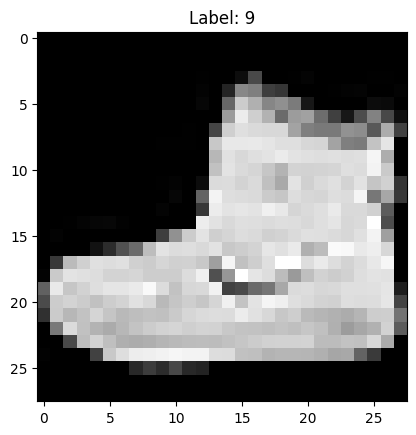

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(x_train[0], cmap='gray')
plt.title(f"Label: {y_train[0]}")
plt.show()

# **initialize**

In [ ]:
rbm = RBM(n_visible=784, n_hidden=128, lr=0.01, epochs=15, mode='bernoulli')

batch_size = 64
num_batches = x_train_flat.shape[0] // batch_size
for epoch in range(rbm.epochs):
    perm = np.random.permutation(x_train_flat.shape[0])
    x_train_shuffled = x_train_flat[perm]
    epoch_loss = []

    for i in range(num_batches):
        batch = x_train_shuffled[i*batch_size:(i+1)*batch_size]
        train_ops = rbm.update(batch, K=1)
        # Run the train ops inside a TF session/eager
        tf.keras.backend.batch_get_value(train_ops)  # Execute the assignments
        epoch_loss.append(rbm.rec_error.numpy())
    print(f"Epoch {epoch+1}/{rbm.epochs}, Reconstruction error: {np.mean(epoch_loss):.4f}")


Epoch 1/15, Reconstruction error: 0.0694
Epoch 2/15, Reconstruction error: 0.0519
Epoch 3/15, Reconstruction error: 0.0485
Epoch 4/15, Reconstruction error: 0.0465
Epoch 5/15, Reconstruction error: 0.0451
Epoch 6/15, Reconstruction error: 0.0441
Epoch 7/15, Reconstruction error: 0.0433
Epoch 8/15, Reconstruction error: 0.0427
Epoch 9/15, Reconstruction error: 0.0421
Epoch 10/15, Reconstruction error: 0.0416
Epoch 11/15, Reconstruction error: 0.0412
Epoch 12/15, Reconstruction error: 0.0408
Epoch 13/15, Reconstruction error: 0.0404
Epoch 14/15, Reconstruction error: 0.0401
Epoch 15/15, Reconstruction error: 0.0398


In [ ]:
train_features = rbm.transform(x_train_flat).numpy()
test_features = rbm.transform(x_test_flat).numpy()

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
y_train_cat = to_categorical(y_train, 10)
y_test_cat = to_categorical(y_test, 10)

mlp = Sequential([
    Dense(64, activation='relu', input_shape=(rbm.n_hidden,)),
    Dense(10, activation='softmax')
])
mlp.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

mlp.fit(train_features, y_train_cat, epochs=20, batch_size=64, validation_split=0.1)

Epoch 1/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6299 - loss: 1.0912 - val_accuracy: 0.7375 - val_loss: 0.6395
Epoch 2/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7333 - loss: 0.6406 - val_accuracy: 0.7523 - val_loss: 0.6063
Epoch 3/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7436 - loss: 0.6132 - val_accuracy: 0.7535 - val_loss: 0.5977
Epoch 4/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7491 - loss: 0.5964 - val_accuracy: 0.7562 - val_loss: 0.5909
Epoch 5/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7579 - loss: 0.5822 - val_accuracy: 0.7573 - val_loss: 0.5860
Epoch 6/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7533 - loss: 0.5815 - val_accuracy: 0.7597 - val_loss: 0.5755
Epoch 7/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7583 - loss: 0.5783 - val_accuracy: 0.7603 - val_loss: 0.5718
Epoch 8/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7586 - loss: 0.5735 - val_accuracy: 0.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Build MLP classifier using raw images
mlp_raw = Sequential([
    Dense(256, activation='relu', input_shape=(784,)),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax')
])

mlp_raw.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

# Train the MLP on raw images
mlp_raw.fit(x_train_flat, y_train_cat, epochs=20, batch_size=64, validation_split=0.1)

# Evaluate on test images
test_loss_raw, test_acc_raw = mlp_raw.evaluate(x_test_flat, y_test_cat)
print(f"Test accuracy on raw images: {test_acc_raw:.4f}")


Epoch 1/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.7674 - loss: 0.6550 - val_accuracy: 0.8605 - val_loss: 0.3851
Epoch 2/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.8621 - loss: 0.3803 - val_accuracy: 0.8713 - val_loss: 0.3582
Epoch 3/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.8758 - loss: 0.3386 - val_accuracy: 0.8618 - val_loss: 0.3939
Epoch 4/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.8821 - loss: 0.3129 - val_accuracy: 0.8782 - val_loss: 0.3333
Epoch 5/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.8925 - loss: 0.2878 - val_accuracy: 0.8797 - val_loss: 0.3364
Epoch 6/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.9003 - loss: 0.2715 - val_accuracy: 0.8752 - val_loss: 0.3408
Epoch 7/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.9037 - loss: 0.2614 - val_accuracy: 0.8800 - val_loss: 0.3313
Epoch 8/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.9051 - loss: 0.2541 - val_accuracy:

In [ ]:
# Evaluate MLP on RBM features
loss_rbm, acc_rbm = mlp.evaluate(test_features, y_test_cat, verbose=0)
print(f"MLP on RBM features - Test Loss: {loss_rbm:.4f}, Test Accuracy: {acc_rbm:.4f}")

# Evaluate MLP on raw images
loss_raw, acc_raw = mlp_raw.evaluate(x_test_flat, y_test_cat, verbose=0)
print(f"MLP on raw images - Test Loss: {loss_raw:.4f}, Test Accuracy: {acc_raw:.4f}")


MLP on RBM features - Test Loss: 0.5932, Test Accuracy: 0.7546
MLP on raw images - Test Loss: 0.3696, Test Accuracy: 0.8927
